# Population Fisher estimates for a gaussian toy model

The purpose of this code is to check the precision attained with Fisher estimates from a Fisher Information Matrix for population parameters. We choose to work with a *simple gaussian model*, in such a way that the Fisher estimates can be obtained analytically. 

The MCMC results can be obtained in a separate notebook and are simply loaded here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import matplotlib as mpl
import seaborn as sns
import pickle


%matplotlib inline
np.random.seed(1234)

In [2]:
# Nice plotting options.

params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

### Fisher estimates for case I (no selection effects)

We load the MCMC results here.

In [3]:
with open('data_files/mu_samples_N=1e5.pickle', 'rb') as handle:
    mu_samples = pickle.load(handle)
with open('data_files/Sigma2_samples_N=1e5.pickle', 'rb') as handle:
    Sigma2_samples = pickle.load(handle)

Here we report the true values and other global parameters used in the loaded simulations.

In [4]:
N_obs = 100000
true_mu = 0.5
true_Sigma_sq = 1.5
Sigma = np.sqrt(true_Sigma_sq)
sigma = 0.2
std = np.sqrt(Sigma**2 + sigma**2)
data  = np.random.normal(true_mu,std,size=N_obs)

We need the model used to plot our Fisher predictions against the MCMC results.

In [5]:
def model(d,mu,Sigma_sq):
    
    """
    Model for p(d|lambda).
    
    Input:
    
    - data              (The noisy generated data where we expect theta to be.)
    - mu                (First  hyperparameter, "param[0]" in MCMC initialization.)
    - Sigma^2 + sigma^2 (Second hyperparameter, "param[1]" in MCMC initialization.)
    
    """
    num = np.exp(-0.5*(d-mu)**2/Sigma_sq)
    den = np.sqrt(2*np.pi*Sigma_sq)
    return num/den

The Fisher matrix for the simple Gaussian case without selection effects is found to be

$$
\Gamma_\lambda = \begin{pmatrix}
\Gamma_{\mu\mu} & \Gamma_{\mu\Sigma^2}\\
\Gamma_{\mu\Sigma^2} & \Gamma_{\Sigma^2\Sigma^2}
\end{pmatrix}
$$

with 

$$
\Gamma_{\mu\mu}= \frac{1}{\sigma^2+\Sigma^2}, \quad \Gamma_{\mu\Sigma^2} = 0,\quad \Gamma_{\Sigma^2\Sigma^2} = \frac{1}{2(\sigma^2+\Sigma^2)^2}.
$$

[Details on how to obtain these are included in the paper.]

In [6]:
Gamma_mu_mu = 1/(sigma**2 + true_Sigma_sq)
Gamma_Ssq_Ssq = 0.5*1/(sigma**2 + true_Sigma_sq)**2

Gamma_lambda = [[Gamma_mu_mu,0],[0,Gamma_Ssq_Ssq]]
Gamma_lambda_inv = np.linalg.inv(Gamma_lambda)

To match the width from the MCMC results we need to normalize the Fisher matrix results by the number of observed events (the $N^{-1/2}$) factor. That is because the matrix is derived for an individual observation, while the MCMC results are obtained with $N$-long data arrays.

In [7]:
Dlambda_diag = 1/np.sqrt(N_obs) *  np.sqrt(np.diag(Gamma_lambda_inv)) #renormalization.
Dmu, DSigma_sq = Dlambda_diag[0], Dlambda_diag[1]

We can check that the Fisher estimates agree with the variance of the samples, and more directly against the posterior distributions. 

FM (full) widths [0.00392428 0.00688709]
MCMC widths: [0.00392395, 0.00694604]


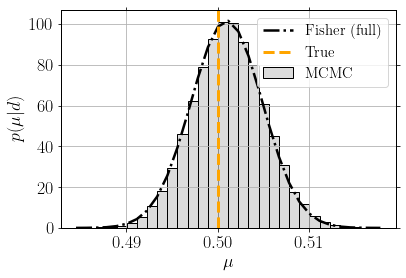

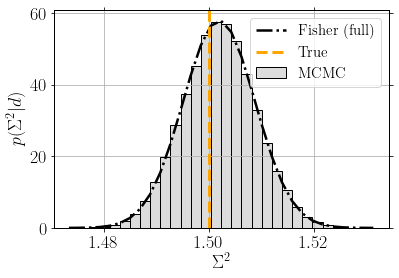

In [9]:
print('FM (full) widths',Dlambda_diag)
print('MCMC widths:',[np.round(np.sqrt(np.var(mu_samples)),8),np.round(np.sqrt(np.var(Sigma2_samples)),8)])


"""
Posteriors with Fisher estimates
"""

truths=[true_mu, true_Sigma_sq]

_, bins_mu, _= plt.hist(mu_samples, 30, histtype = 'bar',
                               color ='gainsboro', density=True, edgecolor='black', label='MCMC')

bins_mu= np.array(bins_mu)
plt.plot(bins_mu, model(bins_mu,true_mu + 0.001,Dmu**2), color='black', ls='-.', 
         lw=2.5, label='Fisher (full)')

plt.axvline(x=truths[0], label='True', c='orange',ls='--',lw=3)
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|d)$')
plt.legend()
plt.show()

_, bins_Ssq, _=plt.hist(Sigma2_samples, 30, histtype = 'bar',
                        color ='gainsboro', density=True, edgecolor='black', 
                        label='MCMC')

bins_Ssq= np.array(bins_Ssq)
plt.plot(bins_Ssq, model(bins_Ssq,true_Sigma_sq+0.002,DSigma_sq**2), color='black', ls='-.',
         lw=2.5,label='Fisher (full)')

plt.axvline(x=truths[1], label='True', c='orange',ls='--', lw=3)
plt.xlabel('$\Sigma^2$')
plt.ylabel('$p(\Sigma^2|d)$')
plt.legend()
plt.show()

### Fisher estimates for case II (with selection effects)

Load data for MCMC results with selection effects.

In [10]:
with open('data_files/mu_samples_selbias_N=1e5.pickle', 'rb') as handle:
    mu_samples_selbias = pickle.load(handle)
with open('data_files/Sigma2_samples_selbias_N=1e5.pickle', 'rb') as handle:
    Sigma2_samples_selbias = pickle.load(handle)

Specify the same threshold used in the MCMC analysis.

In [11]:
d_th = 0.5 #threshold for data.

data_sel_bias = data[data > d_th]
N_det = len(data_sel_bias)

print('Number detected events:', N_det)

Number detected events: 49932


In the Fisher matrix with selection effects we will make use of the following definitions defined just below,

$$
    p_\text{det}(\lambda) = \frac{1}{2}\text{erfc}\left[\frac{d_\text{th}-\mu}{\sqrt{2(\sigma^2+\Sigma^2)}}\right], \quad p(d_\text{th}|\lambda) = \frac{1}{\sqrt{2\pi (\sigma^2+\Sigma^2)}} \exp\left[-\frac{(d_\text{th}-\mu)^2}{2(\sigma^2+\Sigma^2)}\right]
$$

In [12]:
from scipy.special import erfc

# Useful definitions

sigmasq_plus_Sigmasq =  true_Sigma_sq +sigma**2
pdet_lambda_true = 0.5 * erfc((d_th - true_mu)/np.sqrt(2 * sigmasq_plus_Sigmasq))
pof_dth_lambda = np.exp(-0.5* (d_th - true_mu)**2/sigmasq_plus_Sigmasq)/np.sqrt(2*np.pi * sigmasq_plus_Sigmasq)

The Fisher matrix is now defined as

$$
\Gamma_\lambda = \begin{pmatrix}
\Gamma_{\mu\mu} & \Gamma_{\mu\Sigma^2}\\
\Gamma_{\mu\Sigma^2} & \Gamma_{\Sigma^2\Sigma^2}
\end{pmatrix}
$$

with 

$$
\Gamma_{\mu\mu}= \frac{1}{\sigma^2+\Sigma^2} + \frac{\partial^2 \ln p_\text{det}(\lambda)}{\partial \mu^2}, \quad \Gamma_{\mu\Sigma^2} = \frac{1}{\sigma^2+\Sigma^2} \frac{p(d_\text{th}|\lambda)}{p_\text{det}(\lambda)} + \frac{\partial^2 \ln p_\text{det}(\lambda)}{\partial \mu\partial\Sigma^2},\\
\Gamma_{\Sigma^2\Sigma^2} = \frac{1}{2(\sigma^2+\Sigma^2)^2}\frac{(d_\text{th}-\mu)}{(\sigma^2+\Sigma^2)^2}\frac{p(d_\text{th}|\lambda)}{p_\text{det}(\lambda)}+ \frac{\partial^2 \ln p_\text{det}(\lambda)}{\partial \Sigma^2\Sigma^2}.
$$

The derivatives read

$$
\frac{\partial^2 \ln p_\text{det}(\lambda)}{(\partial \mu)^2} =\left(\frac{d_\text{th}-\mu}{\sigma^2+\Sigma^2}\right)\frac{p(d_\text{th}|\lambda)}{p_\text{det}(\lambda)}-\frac{p(d_\text{th}|\lambda)^2}{p_\text{det}(\lambda)^2},\\
\frac{\partial^2 \ln p_\text{det}(\lambda)}{\partial \mu\partial\Sigma^2} =p(d_\text{th}|\lambda)\left[\frac{(d_\text{th}-\mu)^2}{2p_\text{det}(\lambda)(\sigma^2+\Sigma^2)^2}-\frac{1}{2p_\text{det}(\lambda)(\sigma^2+\Sigma^2)}\right] -\frac{p(d_\text{th}|\lambda)^2}{2 p_\text{det}(\lambda)^2}\left(\frac{d_\text{th}-\mu}{\sigma^2+\Sigma^2}\right),\\
\frac{\partial^2 \ln p_\text{det}(\lambda)}{(\partial \Sigma^2)^2}=p(d_\text{th}|\lambda)\left[\frac{(d_\text{th}-\mu)^3}{4p_\text{det}(\lambda)(\sigma^2+\Sigma^2)^3}-\frac{3(d_\text{th}-\mu)}{4p_\text{det}(\lambda)(\sigma^2+\Sigma^2)^2}\right]-\frac{p(d_\text{th}|\lambda)^2}{4 p_\text{det}(\lambda)^2}\left(\frac{d_\text{th}-\mu}{\sigma^2+\Sigma^2}\right)^2.
$$

The expressions as coded up below have been manipulated with $\texttt{Mathematica}$ (see notebook in the same folder).

In [13]:
dpdet_dmu_sq = (d_th - true_mu) * pof_dth_lambda /(sigmasq_plus_Sigmasq *pdet_lambda_true) - pof_dth_lambda**2 / pdet_lambda_true**2
dpdet_dmudSigmasq = 0.5 * pof_dth_lambda**2 * (- d_th +true_mu)/(pdet_lambda_true**2 * sigmasq_plus_Sigmasq)+ 0.5 * pof_dth_lambda* ((d_th-true_mu)**2/(pdet_lambda_true*sigmasq_plus_Sigmasq**2)-1/(pdet_lambda_true*sigmasq_plus_Sigmasq))
dpdet_dSigmasq_sq = -1./4. * pof_dth_lambda**2* (d_th - true_mu)**2 /(pdet_lambda_true**2 * sigmasq_plus_Sigmasq**2) +pof_dth_lambda* ((d_th-true_mu)**3/(4*pdet_lambda_true*sigmasq_plus_Sigmasq**3)-3.*(d_th-true_mu)/(4.*pdet_lambda_true*sigmasq_plus_Sigmasq**2))

# ALT:
#dpdet_dmudSigmasq =0.5 * pof_dth_lambda *  (d_th**2 - 2 * d_th * true_mu + true_mu**2 - sigmasq_plus_Sigmasq)/ sigmasq_plus_Sigmasq**2/pdet_lambda_true -0.5 * pof_dth_lambda**2 / pdet_lambda_true**2 * (d_th - true_mu)/ sigmasq_plus_Sigmasq
#dpdet_dSigmasq_sq =1./4. * (d_th - true_mu) * pof_dth_lambda* (d_th**2 - 2 * d_th * true_mu + true_mu**2 -3* sigmasq_plus_Sigmasq)/sigmasq_plus_Sigmasq**3/pdet_lambda_true - 1./4.* pof_dth_lambda**2 / pdet_lambda_true**2 * (d_th - true_mu)**2/ sigmasq_plus_Sigmasq**2

In [14]:
Gamma_mu_mu_selbias = 1/sigmasq_plus_Sigmasq + dpdet_dmu_sq
Gamma_mu_Ssq_selbias = 1/sigmasq_plus_Sigmasq * pof_dth_lambda/pdet_lambda_true + dpdet_dmudSigmasq
Gamma_Ssq_Ssq_selbias = 0.5 * 1/sigmasq_plus_Sigmasq**2 + (d_th - true_mu)/sigmasq_plus_Sigmasq**2 * pof_dth_lambda/pdet_lambda_true + dpdet_dSigmasq_sq 

Build up the Fisher matrix.

In [15]:
Gamma_lambda_selbias =[[Gamma_mu_mu_selbias,Gamma_mu_Ssq_selbias],[Gamma_mu_Ssq_selbias,Gamma_Ssq_Ssq_selbias]]
Gamma_lambda_selbias_inv = np.linalg.inv(Gamma_lambda_selbias)

And normalize it by the number of observed events (NOT the underlying population).

In [16]:
# Full

Dlambda_diag_selbias = 1/np.sqrt(N_det) *  np.sqrt(np.diag(Gamma_lambda_selbias_inv))
Dmu_selbias, DSigma_sq_selbias = Dlambda_diag_selbias[0], Dlambda_diag_selbias[1]

We can check that the Fisher estimates agree with the variance of the samples, and more directly against the posterior distributions. 

FM (full) widths [0.02615926 0.02767461]
MCMC widths: [0.0245714, 0.0261802]


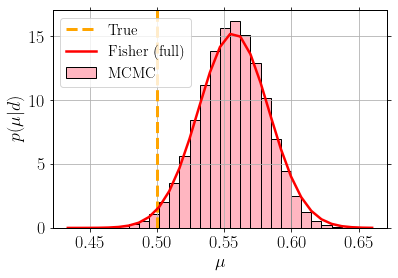

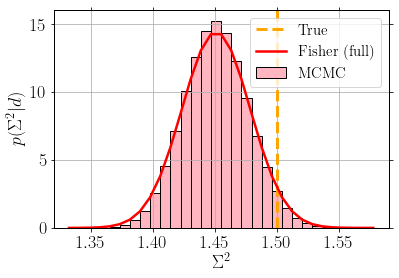

In [17]:
print('FM (full) widths',Dlambda_diag_selbias)
print('MCMC widths:',[np.round(np.sqrt(np.var(mu_samples_selbias)),8),np.round(np.sqrt(np.var(Sigma2_samples_selbias)),8)])


"""
Posteriors with Fisher estimates
"""


# Mean

plt.axvline(x=truths[0], label='True', c='orange',linestyle='--',lw=3)
_, bins_selbias_mu, _= plt.hist(mu_samples_selbias, 30, histtype = 'bar',
                               color ='lightpink', density=True, edgecolor='black', label='MCMC')
bins_selbias_mu= np.array(bins_selbias_mu)
plt.plot(bins_selbias_mu, model(bins_selbias_mu,true_mu+0.057,Dmu_selbias**2),
         color='red', lw=2.5, label='Fisher (full)')

plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|d)$')
plt.legend()
plt.show()

# Variance

plt.axvline(x=truths[1], label='True', c='orange',linestyle='--',lw=3)
_, bins_selbias_Ssq, _=plt.hist(Sigma2_samples_selbias, 30, histtype = 'bar',
                               color ='lightpink', density=True, edgecolor='black', label='MCMC')
bins_selbias_Ssq= np.array(bins_selbias_Ssq)
plt.plot(bins_selbias_Ssq, model(bins_selbias_Ssq,true_Sigma_sq-0.049,DSigma_sq_selbias**2), 
         color='red', lw=2.5, label='Fisher (full)')

plt.xlabel('$\Sigma^2$')
plt.ylabel('$p(\Sigma^2|d)$')
plt.legend()
plt.show()

### Simplified versions of the Fisher matrix: no selection effects.

A simplified version of the Fisher matrix without selection effects reads

$$
(\Gamma_\lambda)_{ij} = \int \frac{1}{p(\theta|\lambda)}\frac{\partial p(\theta|\lambda)}{\partial \lambda^i}\frac{\partial p(\theta|\lambda)}{\partial \lambda^j}d\theta = \int p(\theta|\lambda)\frac{\partial \ln p(\theta|\lambda)}{\partial \lambda^i}\frac{\partial \ln p(\theta|\lambda)}{\partial \lambda^j}d\theta
$$

We can calculate this easily to give $\Gamma_{\mu\mu}= \frac{1}{\Sigma^2}, \quad \Gamma_{\mu\Sigma^2} = 0,\quad \Gamma_{\Sigma^2\Sigma^2} = \frac{1}{2\Sigma^4}$. We have used that $p(\theta|\lambda)=\mathcal{N}(\mu,\sigma^2+\Sigma^2)$.

The inverse of the Fisher matrix is then

$$
(\Gamma_\lambda)_{ij}^{-1} =\begin{pmatrix}
\Sigma^2 & 0 \\
0 & 2 \Sigma^4
\end{pmatrix}
$$

[Details on how to obtain these are given in the Mathematica notebook in this folder.]

In [18]:
Gamma_lambda_inv_simplified = [[true_Sigma_sq,0],[0,2 * true_Sigma_sq**2 ]]
Dlambda_diag_simplified = 1/np.sqrt(N_obs) *  np.sqrt(np.diag(Gamma_lambda_inv_simplified))
Dmu_simplified, DSigma_sq_simplified = Dlambda_diag_simplified[0], Dlambda_diag_simplified[1]

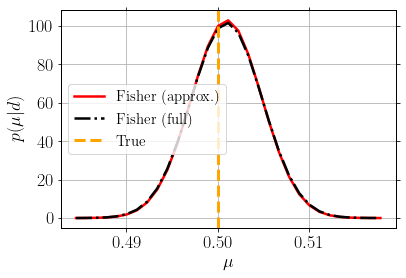

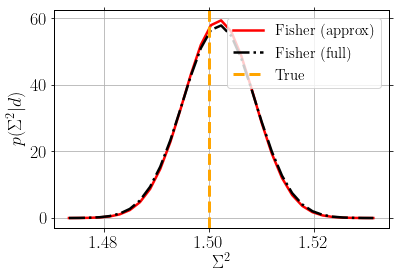

In [19]:
plt.plot(bins_mu, model(bins_mu,true_mu + 0.001,Dmu_simplified**2), color='red', 
         lw=2.5, label='Fisher (approx.)')
plt.plot(bins_mu, model(bins_mu,true_mu + 0.001,Dmu**2), color='black', ls='-.', 
         lw=2.5, label='Fisher (full)')

plt.axvline(x=truths[0], label='True', c='orange',ls='--',lw=3)
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|d)$')
plt.legend()
plt.show()


plt.plot(bins_Ssq, model(bins_Ssq,true_Sigma_sq+0.002,DSigma_sq_simplified**2), color='red', 
         lw=2.5,label='Fisher (approx)')
plt.plot(bins_Ssq, model(bins_Ssq,true_Sigma_sq+0.002,DSigma_sq**2), color='black', ls='-.',
         lw=2.5,label='Fisher (full)')

plt.axvline(x=truths[1], label='True', c='orange',ls='--', lw=3)
plt.xlabel('$\Sigma^2$')
plt.ylabel('$p(\Sigma^2|d)$')
plt.legend()
plt.show()

### Simplified versions of the Fisher matrix: with selection effects.

We can check also a simplified version of the Fisher matrix in this case, in which we only retain the first integral in the (long) population Fisher matrix expression. In the $\texttt{Mathematica}$ notebook, we obtain it to be the expression coded up below.

However the results suggest retaining only the first term is not enough in the presence of selection effects, even in the simple Gaussian toy model.

In [20]:
Gamma_mu_mu_selbias_simp = 1/true_Sigma_sq + dpdet_dmu_sq
Gamma_mu_Ssq_selbias_simp = 1/true_Sigma_sq * pof_dth_lambda/pdet_lambda_true + dpdet_dmudSigmasq
Gamma_Ssq_Ssq_selbias_simp = - 0.5/true_Sigma_sq**2 + true_Sigma_sq + (d_th - true_mu)* true_Sigma_sq**2/sigmasq_plus_Sigmasq**2 * pof_dth_lambda/pdet_lambda_true + dpdet_dSigmasq_sq 

In [21]:
Gamma_lambda_selbias_simp =[[Gamma_mu_mu_selbias_simp,Gamma_mu_Ssq_selbias_simp],[Gamma_mu_Ssq_selbias_simp,Gamma_Ssq_Ssq_selbias_simp]]
Gamma_lambda_selbias_inv_simp = np.linalg.inv(Gamma_lambda_selbias_simp)

In [22]:
# Approximate

Dlambda_diag_selbias_simp = 1/np.sqrt(N_det) *  np.sqrt(np.diag(Gamma_lambda_selbias_inv_simp))
Dmu_selbias_simp, DSigma_sq_selbias_simp = Dlambda_diag_selbias_simp[0], Dlambda_diag_selbias_simp[1]

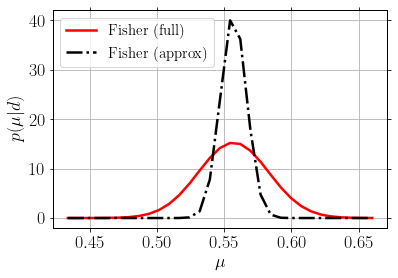

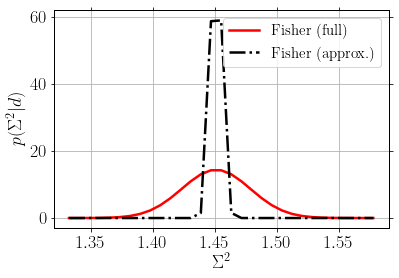

In [23]:
plt.plot(bins_selbias_mu, model(bins_selbias_mu,true_mu+0.057,Dmu_selbias**2),
         color='red', lw=2.5, label='Fisher (full)')
plt.plot(bins_selbias_mu, model(bins_selbias_mu,true_mu+0.057,Dmu_selbias_simp**2),
         color='black', ls='-.', lw=2.5, label='Fisher (approx)')

plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|d)$')
plt.legend()
plt.show()

plt.plot(bins_selbias_Ssq, model(bins_selbias_Ssq,true_Sigma_sq-0.049,DSigma_sq_selbias**2), 
         color='red', lw=2.5, label='Fisher (full)')
plt.plot(bins_selbias_Ssq, model(bins_selbias_Ssq,true_Sigma_sq-0.049,DSigma_sq_selbias_simp**2), 
         color='black', ls='-.', lw=2.5, label='Fisher (approx.)')

plt.xlabel('$\Sigma^2$')
plt.ylabel('$p(\Sigma^2|d)$')
plt.legend()
plt.show()